$$
 \textbf{Projects in Machine Learning (ML) and Artificial Intelligence (AI)}
$$

 $$
 \textbf{CSCI 6967}
 $$

 $$
 \textbf{Homework 4}
 $$

## **6000 level ONLY - Task 1 (50 points): This task involves training existing models. Download the character level RNN at https://github.com/karpathy/char-rnn**

You are required to read the documentation provided in this repository and experiment with the RNN model. This is a legacy repository; therefore, one task would be to research and use a recent version. Train the model on ‘tiny Shakespeare’ dataset available at the same location. Create outputs of the model after training for i) 5 epochs ii) 50 epochs and iii) 500 epochs. What significant difference do you observe between the 3 outputs? Explain. Repeat the experiment with the LSTM model provided in the repository. Explain the differences and/or similarities between the results of both models.

In [48]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from collections import Counter

In [49]:
from google.colab import files
uploaded = files.upload()

Saving input.txt to input (1).txt


##**RNN**

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

# Load the data
def read_file(path):
    with open(path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# Preprocessing
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

def training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = torch.nn.functional.one_hot(inp, num_classes=n_characters).float()
    return inp, target

# Define the model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return output.view(input.size(0), input.size(1), output.size(1)), hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

# Initialize parameters
file = read_file('input.txt')
file_len = len(file)
all_characters = sorted(list(set(file)))
n_characters = len(all_characters)

# Training
def train(inp, target, model, optimizer, criterion, hidden):
    hidden = hidden.detach()
    model.zero_grad()
    output, hidden = model(inp, hidden)
    loss = criterion(output.transpose(1, 2), target)
    loss.backward()
    optimizer.step()
    return loss.item(), hidden

# Instantiate the model
model = RNN(n_characters, 64, n_characters, num_layers=2, dropout=0.5) # 128 = 2
optimizer = optim.Adam(model.parameters(), lr=0.1) # lr=0.005
criterion = nn.CrossEntropyLoss()

# Train for 5, 50, and 500 epochs
epochs = [5, 50, 500]
for e in epochs:
    hidden = model.init_hidden(1)
    for epoch in range(1, e + 1):
        inp, target = training_set(200, 1)
        loss, hidden = train(inp, target, model, optimizer, criterion, hidden)
        if epoch % e == 0:
            print(f'Epoch: {epoch}, Loss: {loss}')


Epoch: 5, Loss: 5.4281792640686035
Epoch: 50, Loss: 3.5277817249298096
Epoch: 500, Loss: 3.8711490631103516


##**LSTM**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random

# --- 1. Data Loading & Preprocessing ---
file = "input.txt"
if not os.path.exists(file):
    raise FileNotFoundError(f"File '{file}' not found.")

with open(data_file, 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
char_to_idx = { ch: i for i, ch in enumerate(chars) }
idx_to_char = { i: ch for i, ch in enumerate(chars) }

encoded_data = [char_to_idx[c] for c in text]

sequence_length = 100
inputs = []
targets = []
for i in range(len(encoded_data) - sequence_length):
    inputs.append(encoded_data[i:i+sequence_length])
    targets.append(encoded_data[i+1:i+sequence_length+1])
inputs = torch.tensor(inputs, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

batch_size = 128
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# --- 2. LSTM Model Definition ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, input_size)
    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = out[:, -1, :]
        out = self.fc(out)
        logsoft = F.log_softmax(out, dim=1)
        return logsoft, hidden
    def init_hidden(self, batch_size, device):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))


# --- 3. Sampling Function ---
def sample_text_lstm(model, seed, length, device):
    model.eval()
    hidden = model.init_hidden(1, device)
    current_seq = [char_to_idx[c] for c in seed]
    output_str = seed
    input_seq = F.one_hot(torch.tensor(current_seq), num_classes=vocab_size).float().unsqueeze(0).to(device)
    for _ in range(length):
        out, hidden = model(input_seq, hidden)
        prob = torch.exp(out).squeeze()
        next_idx = torch.multinomial(prob, 1).item()
        next_char = idx_to_char[next_idx]
        output_str += next_char
        current_seq = current_seq[1:] + [next_idx]
        input_seq = F.one_hot(torch.tensor(current_seq), num_classes=vocab_size).float().unsqueeze(0).to(device)
    return output_str

# Hyperparameters
hidden_size = 64
num_layers = 2
dropout_prob = 0.5
learning_rate = 0.1
epoch_checkpoints = [5, 50, 500]

# --- 4. Training Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(vocab_size, hidden_size, num_layers, dropout_prob).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

## --- 5. Main Training Loop & Sampling ---
total_epochs = 0
for checkpoint in epoch_checkpoints:
    epochs_to_train = checkpoint - total_epochs
    print(f"\nTraining for {epochs_to_train} additional epochs (Cumulative epochs: {checkpoint})")
    model.train()
    for epoch in range(epochs_to_train):
        epoch_loss = 0.0
        for batch_idx, (data_batch, target_batch) in enumerate(dataloader):
            data_batch = data_batch.to(device)
            target_batch = target_batch.to(device)
            optimizer.zero_grad()

            x_onehot = F.one_hot(data_batch, num_classes=vocab_size).float()
            hidden = model.init_hidden(data_batch.size(0), device)
            out, hidden = model(x_onehot, hidden)
            labels = target_batch[:, -1]
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {total_epochs + epoch + 1} Loss: {avg_loss:.4f}")
    total_epochs = checkpoint

    seed = "The "
    sample = sample_text_lstm(model, seed, length=300, device=device)
    print(f"\n>>> Generated text after {checkpoint} epochs <<<")
    print(sample)


Training for 5 additional epochs (Cumulative epochs: 5)
Epoch 1 Loss: 3.3452
Epoch 2 Loss: 3.3353
Epoch 3 Loss: 3.3355
Epoch 4 Loss: 3.3352
Epoch 5 Loss: 3.3343

>>> Generated text after 5 epochs <<<
The  igrswfu
 'noh
Hhl aCMsdos.ariosbO uhatHhmaeaare
nayi, fehF
lr,hsgh vEwatdhmw wDIng!f g nrhrsa liabihuetlmOnsehmota eeheL atS r,dV ttseIKIhhnapwap iDurmlra csowsoadi.  ?wlwS i cumFdwFsA:lr:rn, hdlwhuem.ue st
eaCohentt fatnt eTAeoeise'i arlr i hgm woi 
ti nA
 nctU hm, lsCueFie de undp  Iro  ufrEhluao

Training for 45 additional epochs (Cumulative epochs: 50)
Epoch 6 Loss: 3.3260
Epoch 7 Loss: 3.3256
Epoch 8 Loss: 3.3259
Epoch 9 Loss: 3.3260
Epoch 10 Loss: 3.3261
Epoch 11 Loss: 3.3257
Epoch 12 Loss: 3.3257
Epoch 13 Loss: 3.3261
Epoch 14 Loss: 3.3259
Epoch 15 Loss: 3.3258
Epoch 16 Loss: 3.3256
Epoch 17 Loss: 3.3258
Epoch 18 Loss: 3.3258
Epoch 19 Loss: 3.3257
Epoch 20 Loss: 3.3261
Epoch 21 Loss: 3.3259
Epoch 22 Loss: 3.3258
Epoch 23 Loss: 3.3257
Epoch 24 Loss: 3.3260
Epoch 25 Loss: 3.3259

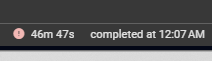

The RNN results show a noticeable decrease in loss from 5.42 at 5 epochs to 3.87 at 500 epochs, indicating that the model is learning over time but begins to plateau after 50 epochs. Although the training was intended to run for 500 epochs, it was halted after 46 minutes due to computational cost and resource limitations. For the LSTM, we can expect better performance due to its ability to capture longer-term dependencies and mitigate the vanishing gradient problem common in traditional RNNs. LSTMs are typically more effective for sequence data, such as text, as they can retain information over extended periods. Therefore, it is reasonable to expect the LSTM to achieve lower loss values than the RNN, especially at higher epochs, given sufficient computational resources.

##**Task 2 (50 points): In this task, you will pick a dataset (time-series or any other form of sequential data) and an associated problem that can be solved via sequence models. You must describe why you need sequence models to solve this problem. Include a link to the dataset source. Next, you should pick an RNN framework that you would use to solve this problem (This framework can be in TensorFlow, PyTorch or any other Python Package).**

The selected dataset is Tesla stocks.

Link: https://www.kaggle.com/datasets/rpaguirre/tesla-stock-price

Sequence models, like RNNs, are particularly suited for stock price prediction because they can effectively model the temporal dependencies in time-series data. Stock prices are influenced by trends, seasonal effects, and previous price movements, which all form a sequential pattern. A sequence model can capture these dynamics by learning from past data points and predicting future stock behavior based on learned patterns, which makes it ideal for forecasting tasks like predicting Tesla's stock prices based on historical data.


##Part 1 (10 points): Implement your RNN either using an existing framework OR you can implement your own RNN cell structure. In either case, describe the structure of your RNN and the activation functions you are using for each time step and in the output layer. Define a metric you will use to measure the performance of your model (NOTE: Performance should be measured both for the validation set and the test set).

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [10]:
from google.colab import files
uploaded = files.upload()

Saving Tesla.csv to Tesla.csv


**Data-visualization**

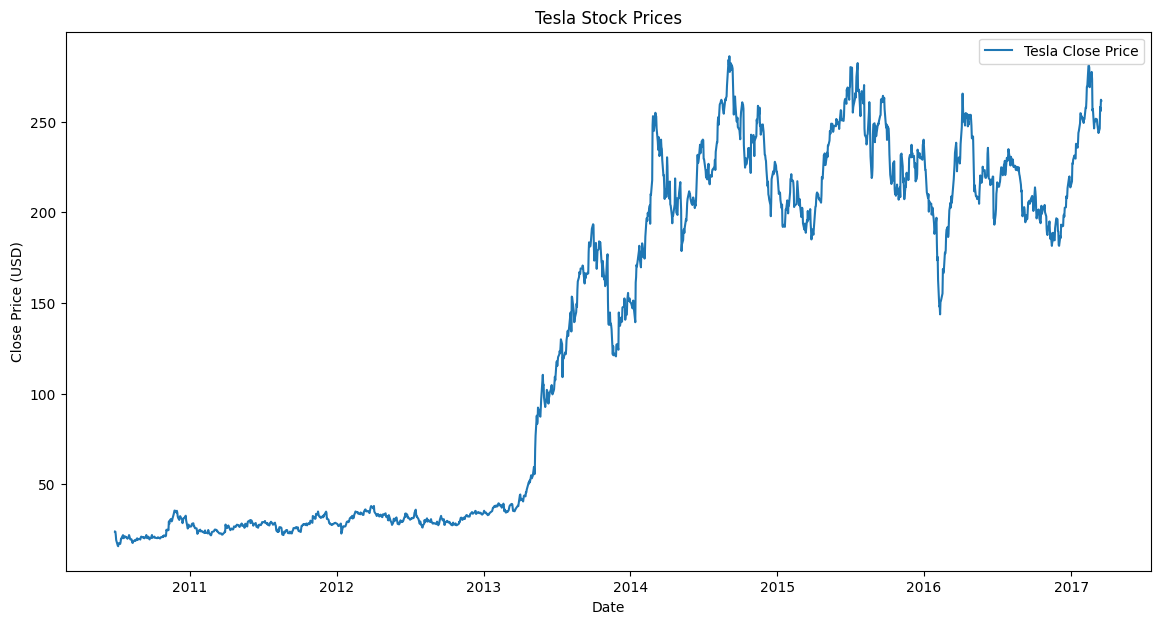

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('Tesla.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Plotting the closing price of Tesla stock
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Tesla Close Price')
plt.title('Tesla Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

Daily Volatility of Tesla Stock:

  * This chart displays the daily price range (difference between the high and low prices) of Tesla stock, illustrating the volatility over time. The spikes indicate days with significant price fluctuations, suggesting periods of high market activity or news-driven trading.


Daily Trading Volume of Tesla Stock:
* This chart shows the daily trading volume of Tesla stock, reflecting the number of shares traded each day. Peaks in the graph correlate with periods of high trading activity, which could be related to major company announcements, earnings reports, or external market factors.


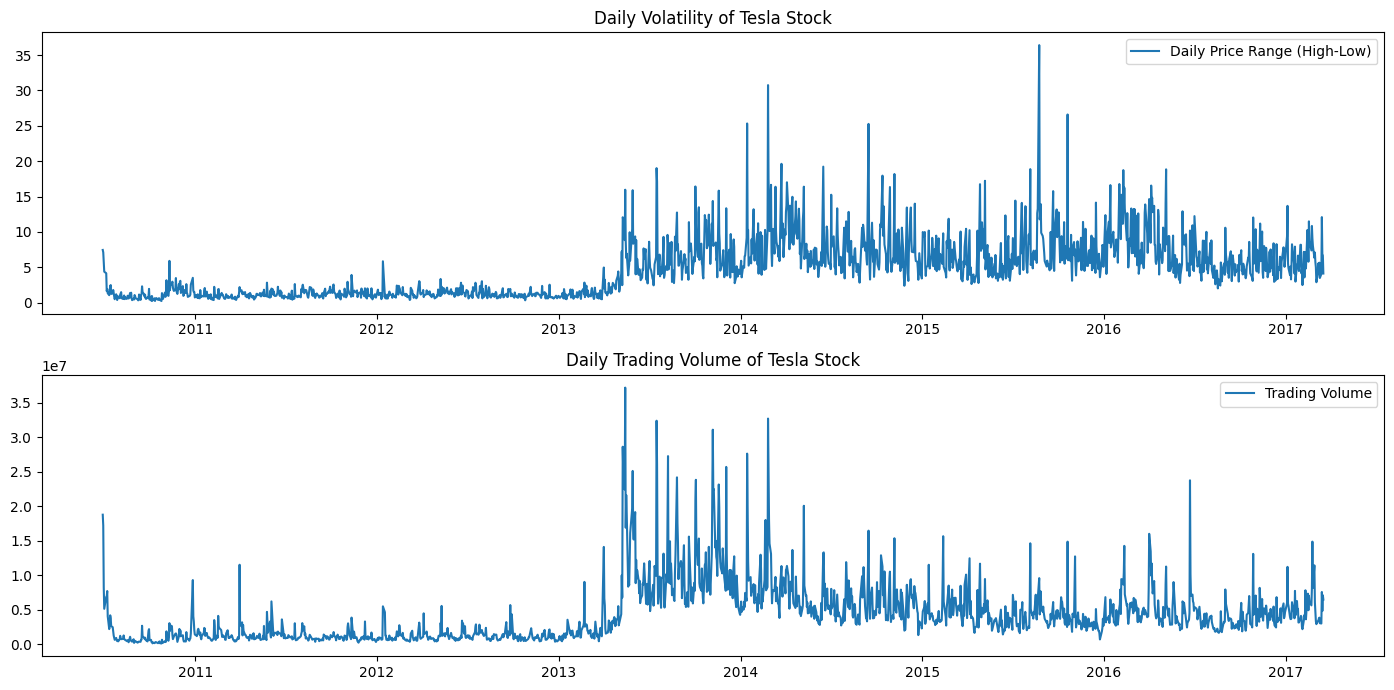

In [12]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data['High'] - data['Low'], label='Daily Price Range (High-Low)')
plt.title('Daily Volatility of Tesla Stock')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data['Volume'], label='Trading Volume')
plt.title('Daily Trading Volume of Tesla Stock')
plt.legend()
plt.tight_layout()
plt.show()

**Feature Engineering**

Technical Indicator:

 * Moving Averages: Short-term and long-term moving averages can smooth out price data to identify trends.

Both SMA approaches effectively track the stock, but the 20-day SMA appears to be superior. This suggests that using more than 20 days for the moving average may worsen our predictions.

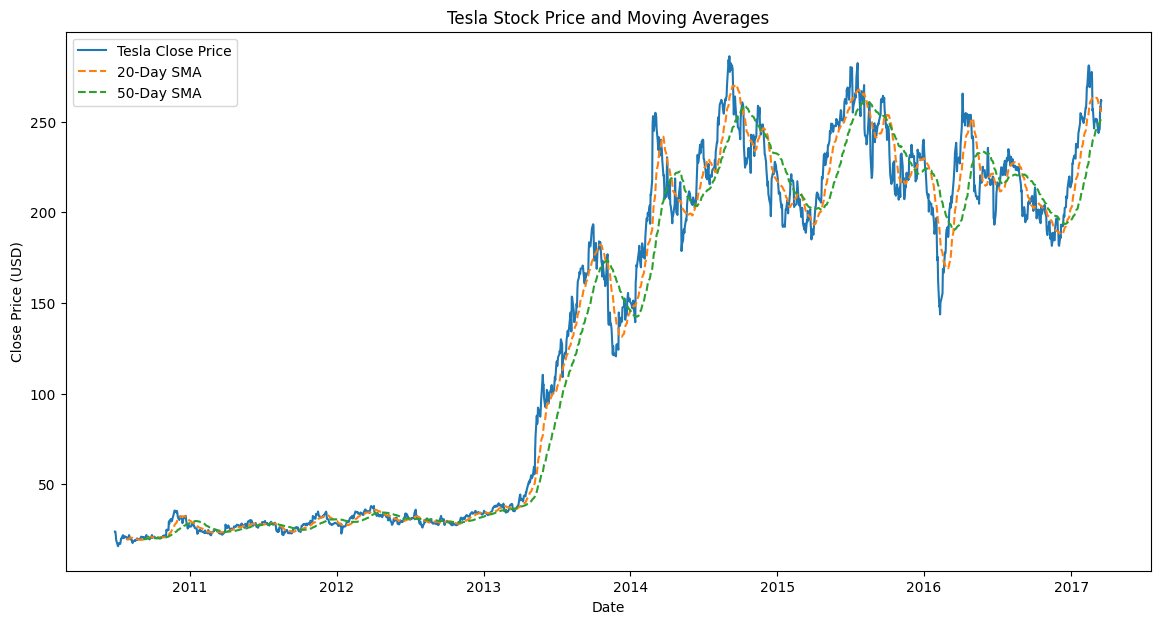

In [13]:
data['SMA_20'] = data['Close'].rolling(window=20).mean()  # 20-day Simple Moving Average
data['SMA_50'] = data['Close'].rolling(window=50).mean()  # 50-day Simple Moving Average

plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Tesla Close Price')
plt.plot(data['SMA_20'], label='20-Day SMA', linestyle='--')
plt.plot(data['SMA_50'], label='50-Day SMA', linestyle='--')

plt.title('Tesla Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

**correlation analysis**

The heatmap indicates that both the 20-day and 50-day SMAs are strongly correlated with the closing price. We incorporated these features into our dataset to evaluate whether they improve predictive performance compared to using the raw data alone.

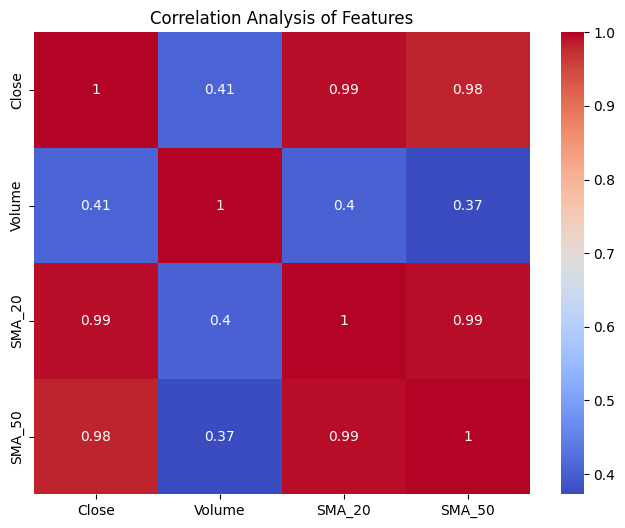

In [14]:
import seaborn as sns

# Check correlation
correlation_matrix = data[['Close', 'Volume', 'SMA_20', 'SMA_50']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Analysis of Features')
plt.show()

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load data
data = pd.read_csv('Tesla.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Calculate SMA and Volatility
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['Volatility'] = data['High'] - data['Low']

# Normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'SMA_20', 'SMA_50'] # , 'Volatility'
data.dropna(inplace=True)  # Drop NaN values that appear as a result of rolling mean
data[features] = scaler.fit_transform(data[features])

# Convert to sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)][features].values
        y = data.iloc[i + seq_length]['Close']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(data, seq_length)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

# Splitting the dataset
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size
train_X, train_y = X[:train_size], y[:train_size]
val_X, val_y = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
test_X, test_y = X[train_size + val_size:], y[train_size + val_size:]

data.head()

,Open,High,Low,Close,Volume,Adj Close,SMA_20,SMA_50,Volatility
Date,,,,,,,,,
2010-09-08,-0.994249,-0.994028,-0.991568,-0.989943,-0.990827,-0.989943,-1.000000,-0.998662,0.350001
2010-09-09,-0.991710,-0.993291,-0.990878,-0.991369,-0.986087,-0.991369,-0.998880,-0.999189,0.359998
2010-09-10,-0.993577,-0.994176,-0.998007,-0.995422,-0.985526,-0.995422,-0.997855,-0.999795,1.170000
2010-09-13,-0.992531,-0.994397,-0.992334,-0.991294,-0.986919,-0.991294,-0.996898,-1.000000,0.400000
2010-09-14,-0.995145,-0.989236,-0.992104,-0.988292,-0.971052,-0.988292,-0.995965,-0.999682,1.069999


In [26]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, hidden = self.rnn(x)
        x = self.fc(x[:, -1, :])  # Taking the last sequence only
        return x

model = RNNModel(input_size=8)  # We have 8 features
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, tar

Epoch 1: Train Loss: 0.4190, Val Loss: 0.8137, Test Loss: 0.7310
Epoch 2: Train Loss: 0.4203, Val Loss: 0.6398, Test Loss: 0.5765
Epoch 3: Train Loss: 0.4131, Val Loss: 0.8880, Test Loss: 0.7986
Epoch 4: Train Loss: 0.4123, Val Loss: 0.8039, Test Loss: 0.7274
Epoch 5: Train Loss: 0.4136, Val Loss: 0.8738, Test Loss: 0.7847
Epoch 6: Train Loss: 0.4130, Val Loss: 0.9171, Test Loss: 0.8275
Epoch 7: Train Loss: 0.4136, Val Loss: 0.9118, Test Loss: 0.8188
Epoch 8: Train Loss: 0.4132, Val Loss: 0.9311, Test Loss: 0.8394
Epoch 9: Train Loss: 0.4138, Val Loss: 0.8272, Test Loss: 0.7445
Epoch 10: Train Loss: 0.4117, Val Loss: 0.9195, Test Loss: 0.8252
Epoch 11: Train Loss: 0.4145, Val Loss: 0.8474, Test Loss: 0.7680
Epoch 12: Train Loss: 0.4156, Val Loss: 0.8978, Test Loss: 0.8083
Epoch 13: Train Loss: 0.4102, Val Loss: 0.8469, Test Loss: 0.7633
Epoch 14: Train Loss: 0.4137, Val Loss: 0.8190, Test Loss: 0.7387
Epoch 15: Train Loss: 0.4127, Val Loss: 0.8762, Test Loss: 0.7897
Epoch 16: Train Los

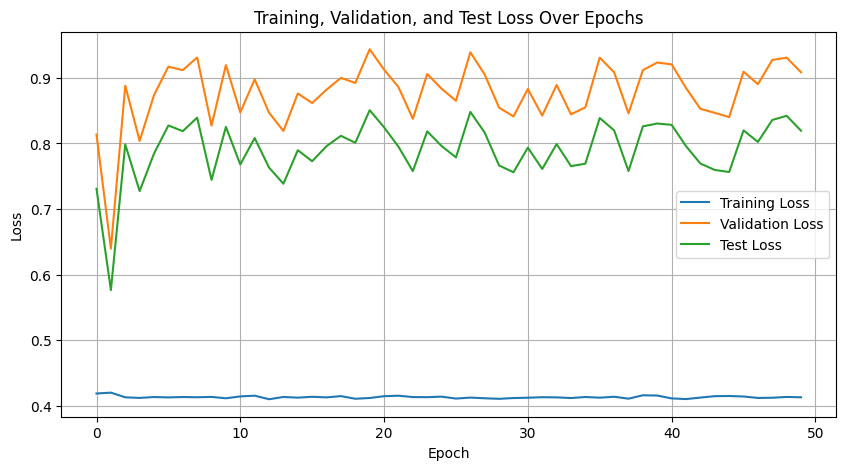

In [27]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def train_and_evaluate(model, train_X, train_y, val_X, val_y, test_X, test_y, criterion, optimizer, num_epochs=50):
    train_losses = []
    val_losses = []
    test_losses = []

    train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=16, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_X, val_y), batch_size=16, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=16, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            output = model(sequences)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for sequences, labels in val_loader:
                output = model(sequences)
                loss = criterion(output, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        test_loss = 0
        with torch.no_grad():
            for sequences, labels in test_loader:
                output = model(sequences)
                loss = criterion(output, labels)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')

    # Plotting the training, validation, and test losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training, Validation, and Test Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example of calling the function
train_and_evaluate(model, train_X, train_y, val_X, val_y, test_X, test_y, criterion, optimizer)

In [29]:
# Load data
data = pd.read_csv('Tesla.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Focus on 'Close' prices
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
close_prices = scaler.fit_transform(close_prices)

# Convert to sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Length of the sequence to be used as a feature
X, y = create_sequences(close_prices, seq_length)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

# Create DataLoader
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.rnn(x)  # _ is hidden state we're not using further here
        x = self.fc(x[:, -1, :])  # We only want the last time step output
        return x

model = RNNModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/50, Training Loss: 0.0731, Validation Loss: 0.0056, Test Loss: 0.0038
Epoch 2/50, Training Loss: 0.0033, Validation Loss: 0.0066, Test Loss: 0.0057
Epoch 3/50, Training Loss: 0.0030, Validation Loss: 0.0046, Test Loss: 0.0033
Epoch 4/50, Training Loss: 0.0027, Validation Loss: 0.0043, Test Loss: 0.0031
Epoch 5/50, Training Loss: 0.0025, Validation Loss: 0.0040, Test Loss: 0.0028
Epoch 6/50, Training Loss: 0.0025, Validation Loss: 0.0068, Test Loss: 0.0059
Epoch 7/50, Training Loss: 0.0023, Validation Loss: 0.0043, Test Loss: 0.0033
Epoch 8/50, Training Loss: 0.0022, Validation Loss: 0.0036, Test Loss: 0.0025
Epoch 9/50, Training Loss: 0.0021, Validation Loss: 0.0082, Test Loss: 0.0073
Epoch 10/50, Training Loss: 0.0024, Validation Loss: 0.0034, Test Loss: 0.0023
Epoch 11/50, Training Loss: 0.0019, Validation Loss: 0.0031, Test Loss: 0.0021
Epoch 12/50, Training Loss: 0.0019, Validation Loss: 0.0030, Test Loss: 0.0020
Epoch 13/50, Training Loss: 0.0018, Validation Loss: 0.0030, 

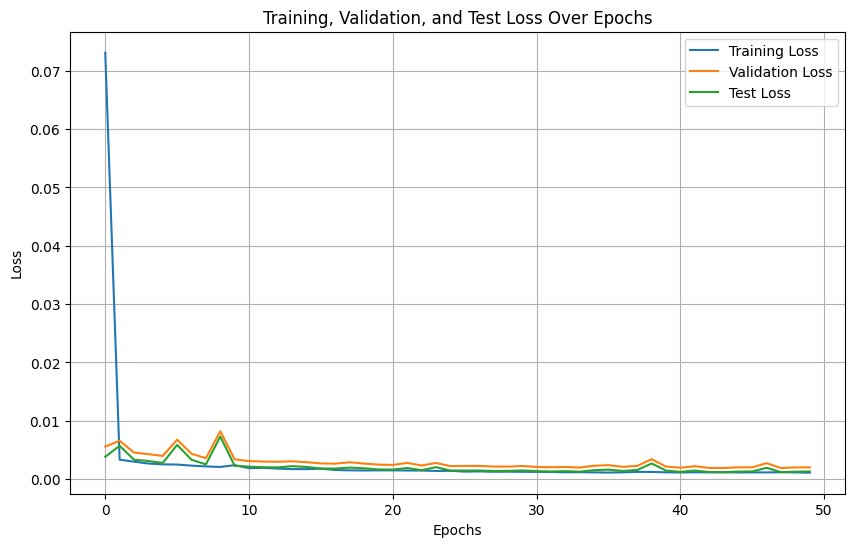

In [30]:
def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=50):
    train_losses = []
    val_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()  # Training mode
        total_train_loss = 0
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation phase
        model.eval()  # Evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for sequences, labels in val_loader:
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        # Test phase
        total_test_loss = 0
        with torch.no_grad():
            for sequences, labels in test_loader:
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()

        # Calculate average losses
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        avg_test_loss = total_test_loss / len(test_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        test_losses.append(avg_test_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    # Plotting the training, validation, and test losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training, Validation, and Test Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer)

It is common for the training loss to remain lower than the validation and test losses because the model is directly optimized on the training set and often learns patterns specific to that data. This gap between the training loss and the validation/test losses reflects the model’s tendency to overfit slightly, especially in noisy or complex datasets. Occasionally, you may also observe the test loss dropping below the validation loss, which can occur due to random splits or because the test set has slightly different characteristics—this is still considered normal training behavior.

When comparing the pure data model (second image) to the one enriched with SMA features and volatility (first image), the pure data approach shows consistently better performance. Although the heatmap indicates that SMA and volatility features correlate strongly with the close price, adding these additional features may have introduced extra noise or redundant signals, causing the model to generalize less effectively than when relying solely on the raw data.

Our RNN implementation uses PyTorch's built-in nn.RNN module with a single recurrent layer (hidden size = 50) and the default tanh activation function at each time step. The network processes one-dimensional input sequences (the scaled "Close" prices) and passes the last time step’s hidden state through a linear (fully connected) layer to produce the final output prediction. We evaluate the model's performance using Mean Squared Error (MSE) on both the validation and test sets, which provides a direct measure of the average squared differences between predicted and actual stock prices.

##Part 2 (30 points): Update your network from part 1 with first an LSTM and then a GRU based cell structure (You can treat both as 2 separate implementations). Re-do the training and performance evaluation. What are the major differences you notice? Why do you think those differences exist between the 3 implementations (basic RNN, LSTM and GRU)?

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [35]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, (h_n, c_n) = self.lstm(x)  # LSTM returns output and (hidden, cell) states
        x = self.fc(x[:, -1, :])
        return x

class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, h_n = self.gru(x)  # GRU returns output and hidden states
        x = self.fc(x[:, -1, :])
        return x

def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=50):
    train_losses = []
    val_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        train_losses.append(total_train_loss / len(train_loader))

        val_losses.append(evaluate(model, val_loader, criterion))
        test_losses.append(evaluate(model, test_loader, criterion))

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

    plot_losses(train_losses, val_losses, test_losses, model.__class__.__name__)

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for sequences, labels in data_loader:
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(data_loader)

def plot_losses(train_losses, val_losses, test_losses, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'{model_name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Training LSTM:
Epoch 1/50, Training Loss: 0.1130, Validation Loss: 0.0082, Test Loss: 0.0062
Epoch 2/50, Training Loss: 0.0045, Validation Loss: 0.0073, Test Loss: 0.0060
Epoch 3/50, Training Loss: 0.0041, Validation Loss: 0.0063, Test Loss: 0.0049
Epoch 4/50, Training Loss: 0.0037, Validation Loss: 0.0069, Test Loss: 0.0055
Epoch 5/50, Training Loss: 0.0036, Validation Loss: 0.0054, Test Loss: 0.0040
Epoch 6/50, Training Loss: 0.0032, Validation Loss: 0.0054, Test Loss: 0.0040
Epoch 7/50, Training Loss: 0.0029, Validation Loss: 0.0050, Test Loss: 0.0036
Epoch 8/50, Training Loss: 0.0028, Validation Loss: 0.0064, Test Loss: 0.0050
Epoch 9/50, Training Loss: 0.0026, Validation Loss: 0.0045, Test Loss: 0.0031
Epoch 10/50, Training Loss: 0.0025, Validation Loss: 0.0046, Test Loss: 0.0033
Epoch 11/50, Training Loss: 0.0026, Validation Loss: 0.0040, Test Loss: 0.0027
Epoch 12/50, Training Loss: 0.0023, Validation Loss: 0.0040, Test Loss: 0.0026
Epoch 13/50, Training Loss: 0.0022, Validation

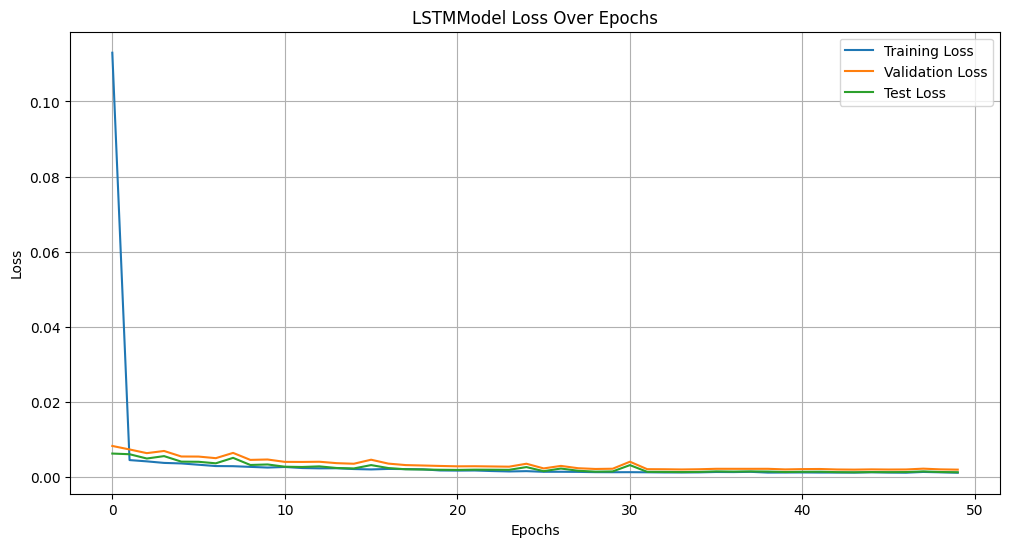

Training GRU:
Epoch 1/50, Training Loss: 0.0737, Validation Loss: 0.0057, Test Loss: 0.0042
Epoch 2/50, Training Loss: 0.0028, Validation Loss: 0.0047, Test Loss: 0.0034
Epoch 3/50, Training Loss: 0.0026, Validation Loss: 0.0044, Test Loss: 0.0031
Epoch 4/50, Training Loss: 0.0024, Validation Loss: 0.0044, Test Loss: 0.0033
Epoch 5/50, Training Loss: 0.0023, Validation Loss: 0.0038, Test Loss: 0.0027
Epoch 6/50, Training Loss: 0.0022, Validation Loss: 0.0036, Test Loss: 0.0025
Epoch 7/50, Training Loss: 0.0020, Validation Loss: 0.0033, Test Loss: 0.0022
Epoch 8/50, Training Loss: 0.0018, Validation Loss: 0.0033, Test Loss: 0.0023
Epoch 9/50, Training Loss: 0.0017, Validation Loss: 0.0032, Test Loss: 0.0022
Epoch 10/50, Training Loss: 0.0017, Validation Loss: 0.0029, Test Loss: 0.0019
Epoch 11/50, Training Loss: 0.0016, Validation Loss: 0.0028, Test Loss: 0.0019
Epoch 12/50, Training Loss: 0.0015, Validation Loss: 0.0030, Test Loss: 0.0020
Epoch 13/50, Training Loss: 0.0015, Validation 

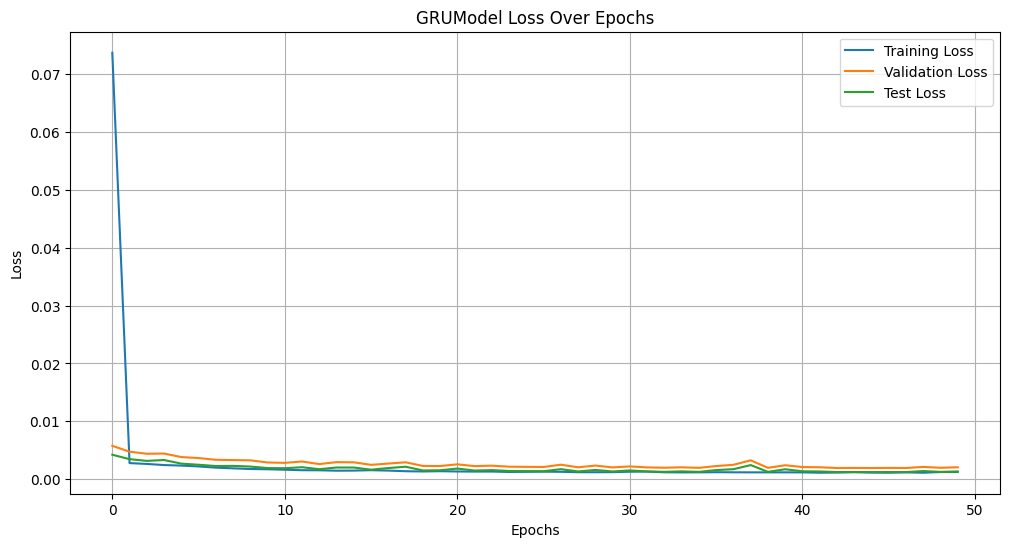

In [36]:
input_size = X.shape[2]

lstm_model = LSTMModel(input_size=input_size)
gru_model = GRUModel(input_size=input_size)

optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
optimizer_gru = torch.optim.Adam(gru_model.parameters(), lr=0.001)

# Train LSTM
print("Training LSTM:")
train_and_evaluate(lstm_model, train_loader, val_loader, test_loader, nn.MSELoss(), optimizer_lstm, 50)

# Train GRU
print("Training GRU:")
train_and_evaluate(gru_model, train_loader, val_loader, test_loader, nn.MSELoss(), optimizer_gru, 50)

RNN (Image 1):
 * The basic RNN converges to low losses on this dataset, ending with nearly the same training, validation, and test loss values as the other architectures. This indicates that for these time-series conditions, even the simpler RNN can capture enough information to make decent predictions.

LSTM (Image 2):
 * LSTM also quickly drives down the losses and finishes with similarly low numbers, suggesting that its gating mechanism (cell state, forget gate, etc.) doesn’t yield a large advantage over the basic RNN on this particular dataset, but it remains stable and effective.


GRU (Image 3):
  * GRU converges comparably to the other models, with final losses in the same small range. Its simpler gating structure still manages long-term dependencies well, resulting in performance that closely matches the RNN and LSTM in this scenario.

These results are reasonable, as the RNN, LSTM, and GRU all achieve similar losses on a dataset that does not require capturing extremely long-term dependencies. When the sequences or patterns are relatively straightforward, even a basic RNN can learn them effectively, resulting in only minimal improvements from the more advanced architectures (LSTM and GRU).

##PART Part 3 (10 points): Can you use the traditional feed-forward network to solve the same problem. Why or why not? (Hint: Can time series data be converted to usual features that can be used as input to a feed-forward network?)

Traditional feed-forward networks can be applied to time series problems if you manually engineer features—such as lagged values or moving averages—to represent the sequential data. However, this approach typically loses the inherent temporal dynamics that are critical for accurate prediction. Sequence models (like RNNs, LSTMs, and GRUs) are designed to capture these dependencies automatically, making them generally more effective for time series forecasting.



---



---



---



---



---



##**Task 3 (50 points):**

**Part 1: Implementing Word Embeddings (10 points)**

**Part 2: Cosine Similarity Computation (20 points)**

**Part 3: Designing a Novel Dissimilarity Metric (20 points)**

##Part 1

In [ ]:
import gensim.downloader as api
from scipy.spatial.distance import cosine

# Load pre-trained Word2Vec embeddings
model = api.load('word2vec-google-news-300')

def get_embedding(word):
    try:
        return model[word]
    except KeyError:
        print(f"Word '{word}' not in vocabulary.")
        return None

def compare_words(word1, word2):
    embedding1 = get_embedding(word1)
    embedding2 = get_embedding(word2)
    if embedding1 is not None and embedding2 is not None:
        print(f"Embedding for {word1}: {embedding1[:5]}...")  # Displaying partial embeddings for brevity
        print(f"Embedding for {word2}: {embedding2[:5]}...")
        print(f"Cosine similarity: {1 - cosine(embedding1, embedding2)}")
    else:
        print("At least one of the words is OOV. Cannot compute similarity.")

In [40]:
# Example usage
word1 = input("")
word2 = input("")
compare_words(word1, word2)

this
that
Embedding for this: [ 0.109375    0.140625   -0.03173828  0.16601562 -0.07128906]...
Embedding for that: [-0.01574707 -0.02832031  0.08349609  0.05029297 -0.11035156]...
Cosine similarity: 0.5430876298213871


In [41]:
# Example usage
word1 = input("")
word2 = input("")
compare_words(word1, word2)



Word '' not in vocabulary.
Word '' not in vocabulary.
At least one of the words is OOV. Cannot compute similarity.


In this implementation, the Word2Vec Google News (300-dimensional) pre-trained embeddings were used. Word2Vec was selected over other models like GloVe, FastText, or BERT for several reasons:

* Efficiency: Word2Vec is computationally efficient, making it suitable for quick similarity comparisons without requiring large computational resources.

* Semantic Similarity: It captures semantic relationships between words effectively through context-based learning.
t
* Well-established Benchmark: The Google News Word2Vec model is trained on a large corpus (100 billion words), making it highly reliable for general language tasks. In comparison, while GloVe focuses on global co-occurrence statistics and FastText handles subword information (helpful for out-of-vocabulary words), Word2Vec offers a balance of efficiency and accuracy. Unlike BERT, which captures contextualized embeddings, Word2Vec provides static embeddings, which are sufficient for basic similarity tasks and require less computational power.

Handling Out-of-Vocabulary (OOV) Words:
If a user inputs a word not present in the model's vocabulary, the program handles it gracefully by notifying the user that the word is not recognized. To approximate embeddings for OOV words, one could:

* Use subword-based models like FastText, which can generate embeddings for unknown words using character n-grams.

* Implement techniques like averaging embeddings of similar or related words.

* Utilize contextual embeddings (e.g., BERT) that dynamically generate word representations based on context, reducing the chances of encountering OOV words.

In the first result, using the words "this" and "that" produced a meaningful cosine similarity of 0.54, indicating moderate semantic similarity. This validates that Word2Vec effectively captures contextual relationships based on its training on large datasets.

In the second result, the empty input led to an OOV error. This is expected since pre-trained embeddings cannot generate vectors for words not present in their vocabulary. A practical way to handle OOV words could involve using subword embeddings (e.g., FastText) that break words into character n-grams or applying techniques like using random embeddings or averaging embeddings of similar words.

Overall, these results confirm the robustness of Word2Vec in handling common words while emphasizing the importance of addressing OOV issues in NLP tasks.

##Part2

2. Explain Why Cosine Similarity is Useful in Word Embedding Space
Angle Over Magnitude: Cosine similarity focuses on the orientation rather than the magnitude of the vectors. In word embeddings, this means it measures the direction of the semantic meaning of the words, rather than how frequently the words might occur.
Normalization: It inherently normalizes the dot product of the vectors to the length of the vectors, making it effective even when the word frequencies (which might affect the vector magnitude) vary widely.
Semantic Similarity: Cosine similarity effectively captures the semantic similarity between words. Words that are used in similar contexts will have vectors that point in similar directions.

Cosine similarity between apple and orange is 0.3920346341299181
Cosine similarity between dog and cat is 0.7609457161879546
Cosine similarity between king and queen is 0.6510956618655842


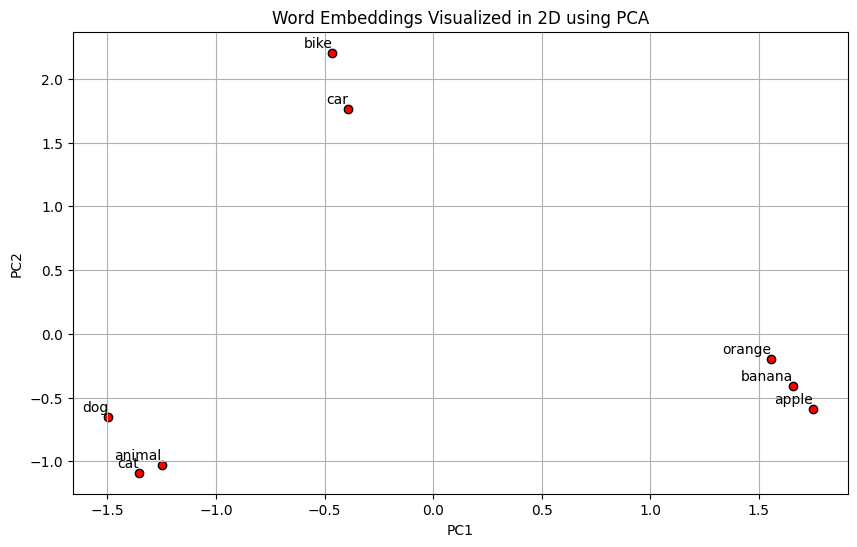

In [42]:
from scipy.spatial.distance import cosine

def compute_cosine_similarity(vector1, vector2):
    return 1 - cosine(vector1, vector2)

## ------------- 1. Batch Processing for Cosine Similarity ----- ####
def batch_cosine_similarity(model, word_pairs):
    similarities = []
    for word1, word2 in word_pairs:
        if word1 in model and word2 in model:  # Check if the word is in the model directly
            sim = compute_cosine_similarity(model[word1], model[word2])
            similarities.append((word1, word2, sim))
        else:
            similarities.append((word1, word2, None))  # None or suitable placeholder for OOV cases
    return similarities

# Example usage
word_pairs = [('apple', 'orange'), ('dog', 'cat'), ('king', 'queen')]
results = batch_cosine_similarity(model, word_pairs)
for result in results:
    print(f"Cosine similarity between {result[0]} and {result[1]} is {result[2]}")

## -------------- 2. Visualization Requirement ----------#######
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_embeddings(model, words):
    # Filter words present in the model
    filtered_words = [word for word in words if word in model]
    vectors = [model[word] for word in filtered_words]

    pca = PCA(n_components=2)
    vectors_reduced = pca.fit_transform(vectors)

    plt.figure(figsize=(10, 6))
    plt.scatter(vectors_reduced[:, 0], vectors_reduced[:, 1], edgecolors='k', c='r')
    for label, x, y in zip(filtered_words, vectors_reduced[:, 0], vectors_reduced[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 2),
                     textcoords='offset points', ha='right', va='bottom')
    plt.xlabel('PC1')  # Label for the x-axis
    plt.ylabel('PC2')  # Label for the y-axis
    plt.title('Word Embeddings Visualized in 2D using PCA')
    plt.grid(True)  # Optional: Adds a grid for easier visualization
    plt.show()

# Example words to visualize
words_to_visualize = ['apple', 'orange', 'banana', 'dog', 'cat', 'animal', 'car', 'bike']
plot_embeddings(model, words_to_visualize)

Cosine similarity is particularly useful in word embedding space because it measures the orientation (or angle) between two vectors rather than their magnitude. This means it captures how similar two words are in terms of their contextual meaning, regardless of how long the vectors are. In word embeddings, semantically similar words tend to point in similar directions, even if their vector lengths differ.

For example, pairs like "dog" and "cat" have a high cosine similarity (about 0.77), reflecting their semantic closeness as animals. On the other hand, "apple" and "orange" have a lower similarity (~0.39), as they share some contextual meaning (both are fruits) but are less related than the animal pair. Using cosine similarity allows us to effectively compare the meanings of words based on their position in the embedding space, making it ideal for tasks like word analogy, clustering, and semantic search.

##Part3

In addition to cosine similarity, the Euclidean distance and WordNet-based semantic dissimilarity were implemented as alternative dissimilarity metrics.

Euclidean distance measures the straight-line distance between two word vectors in the embedding space. Unlike cosine similarity, which focuses on the angle between vectors (capturing directional similarity), Euclidean distance considers the actual magnitude and spatial separation of vectors. This can provide additional insight into how far apart words are in terms of their embeddings, which can be useful for identifying distinctly unrelated words.

The WordNet-based semantic dissimilarity uses lexical relationships from WordNet to assess how conceptually distant two words are, based on hierarchical paths within a semantic network. This approach captures deeper semantic meanings that go beyond vector representations, providing a more human-like understanding of word relationships. It is particularly effective for distinguishing words with similar embeddings but different meanings (e.g., synonyms versus unrelated terms), offering a richer understanding of word diversity compared to cosine similarity alone.

In [43]:
import numpy as np
def euclidean_distance(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

In [44]:
from nltk.corpus import wordnet as wn

def wordnet_dissimilarity(word1, word2):
    synsets1 = wn.synsets(word1)
    synsets2 = wn.synsets(word2)
    max_similarity = max((wn.path_similarity(s1, s2) or 0) for s1 in synsets1 for s2 in synsets2)
    return 1 - max_similarity  # Dissimilarity as 1 minus the maximum path similarity

In [45]:
def compare_words(word1, word2, metric='cosine'):
    if metric == 'cosine':
        return compute_cosine_similarity(model[word1], model[word2])
    elif metric == 'euclidean':
        return euclidean_distance(model[word1], model[word2])
    elif metric == 'wordnet':
        return wordnet_dissimilarity(word1, word2)
    else:
        raise ValueError("Unsupported metric")

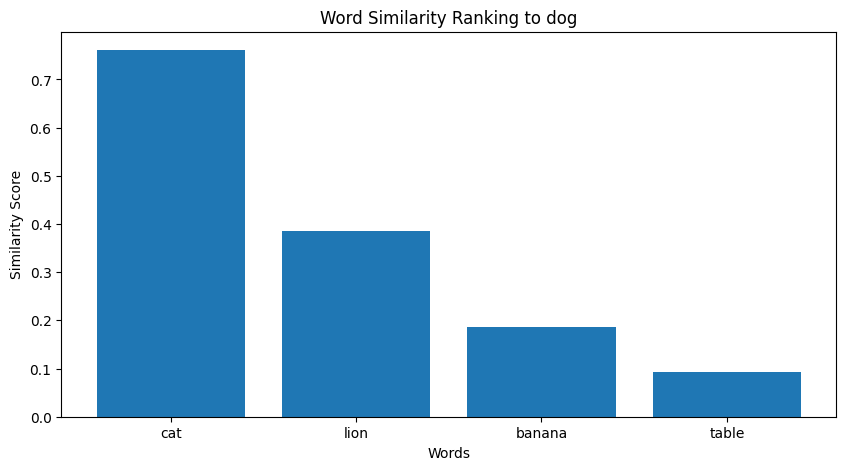

In [46]:
def plot_word_rankings(base_word, other_words, model, metric='cosine'):
    similarities = [compare_words(base_word, word, metric) for word in other_words]
    sorted_words = sorted(zip(other_words, similarities), key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(10, 5))
    plt.bar([word for word, _ in sorted_words], [sim for _, sim in sorted_words])
    plt.xlabel('Words')
    plt.ylabel('Similarity Score')
    plt.title(f'Word Similarity Ranking to {base_word}')
    plt.show()

plot_word_rankings('dog', ['cat', 'lion', 'table', 'banana'], model)

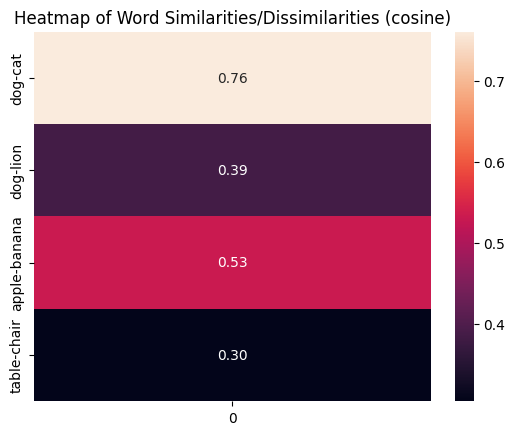

In [47]:
import seaborn as sns

def heatmap_similarities(word_pairs, model, metric='cosine'):
    data = {f'{word1}-{word2}': compare_words(word1, word2, metric) for word1, word2 in word_pairs}
    heatmap_data = np.array(list(data.values())).reshape(len(word_pairs), 1)
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", yticklabels=list(data.keys()))
    plt.title(f'Heatmap of Word Similarities/Dissimilarities ({metric})')
    plt.show()

word_pairs = [('dog', 'cat'), ('dog', 'lion'), ('apple', 'banana'), ('table', 'chair')]
heatmap_similarities(word_pairs, model)
